In [1]:
import sys

sys.path.append("/Users/olivier/PycharmProjects/bayesian-kst/")
from kgraph.expert_layer.domain_graph import DomainGraph
from kgraph.expert_layer.knowledge_components import KnowledgeComponent, ProceduralKnowledgeComponent
from kgraph.expert_layer.links import LinkModel, LinkFromParents, LinkFromChildren
from kgraph.resources_layer.exercise_family import ExerciseFamily
from kgraph.resources_layer.exercise import Exercise
from kgraph.learner_layer.evaluation import Evaluation
from kgraph.learner_layer.learner_pool import LearnerPool
from kgraph.learner_layer.learner import Learner, LearnerGraph
from kgraph.helpers.truthtable import truthtable
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn

## Mise en oeuvre du modèle général dont on cherche les paramètres

In [2]:
def get_two_dbn(domain_graph):
    knowledge_components = domain_graph.get_knowledge_components()
    twodbn = gum.BayesNet()
    
    for kc in knowledge_components:
        twodbn.add(gum.LabelizedVariable(f"{kc.name}0",f"{kc.name}0",2))
        twodbn.add(gum.LabelizedVariable(f"{kc.name}t",f"{kc.name}t",2))
        twodbn.addArc(f"{kc.name}0",f"{kc.name}t")
    for kc in knowledge_components:
        for parent in domain_graph.get_kc_parents(kc):
            twodbn.addArc(f"{parent.name}t",f"{kc.name}t")
            
    return twodbn

In [3]:
# we define the KCs
KC_A = ProceduralKnowledgeComponent(1, "A")
KC_B = ProceduralKnowledgeComponent(2, "B")

# we define the link between the two that gonna lead to the link model
link_a_to_b = LinkFromParents(KC_B, [KC_A], [.4, .6])
link_b_to_a = LinkFromChildren(KC_A, [KC_B], [.1, .9])
link_model = LinkModel([link_a_to_b, link_b_to_a])

domain_graph = DomainGraph([KC_A, KC_B], link_model)

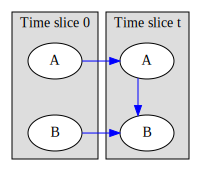

In [4]:
twodbn = get_two_dbn(domain_graph)
gdyn.showTimeSlices(twodbn)

## Application du modèle général sur le cas particulier d'un apprenant

In [5]:
# default params
params = {"slip": .1, "guess":.25}

# we define the exercises that corresponds to KC_A
ex_A_1 = Exercise(1, "qcm", ex_content="", params=params)
ex_A_2 = Exercise(2, "qcm", ex_content="", params=params)
ex_A_3 = Exercise(3, "qcm", ex_content="", params=params)
ex_A_4 = Exercise(4, "qcm", ex_content="", params=params)
ex_A_5 = Exercise(5, "qcm", ex_content="", params=params)

ex_fam_A = ExerciseFamily(1, "ex_fam_A", KC_A, [ex_A_1, ex_A_2, ex_A_3, ex_A_4, ex_A_5])

# we define the exercises that corresponds to KC_A
ex_B_1 = Exercise(6, "qcm", ex_content="", params=params)
ex_B_2 = Exercise(7, "qcm", ex_content="", params=params)
ex_B_3 = Exercise(8, "qcm", ex_content="", params=params)
ex_B_4 = Exercise(9, "qcm", ex_content="", params=params)
ex_B_5 = Exercise(10, "qcm", ex_content="", params=params)

ex_fam_B = ExerciseFamily(1, "ex_fam_B", KC_B, [ex_B_1, ex_B_2, ex_B_3, ex_B_4, ex_B_5])


learner_pool = LearnerPool(domain_graph)
learner_pool.setup_random_learners(1000)
n_evals = 3000
sim_evaluations = learner_pool.simulate_evaluations_from_learners(n_evals)
temp_eval = []
for i in range(len(sim_evaluations)):
    temp = []
    for evaluation in sim_evaluations[i]:
        temp += [(evaluation.get_kc(), int(evaluation.answers[key]["success"])) for key in list(evaluation.answers.keys())]
    temp_eval.append(temp)
sim_evaluations=temp_eval

In [6]:
def get_learner_dbn(twodbn, learner_evals):
    print(learner_evals)
    evidences = {leval[0]: [leval[1], leval[1]-slip] for leval in learner_evals}
    gdyn.plotFollow(["a","b","c","d"],twodbn,T=len(learner_evals),evs=evidences)
    
get_learner_dbn(twodbn, sim_evaluations[0])

[(<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x11d0e7250>, 0), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x11d0e7250>, 1), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x11d0e7250>, 0), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x11d0e7250>, 1), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x11d0e7250>, 1), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x11d0e7250>, 1), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x11d0e7250>, 1), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x11d0e7250>, 1), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x11d0e7250>, 1), (<kgraph.expert_layer.knowledge_components.ProceduralKnowledgeComponent object at 0x11d0e7250>, 0),

TypeError: Wrong number or type of arguments for overloaded function 'LazyPropagation_addEvidence'.
  Possible C/C++ prototypes are:
    gum::LazyPropagation< double >::addEvidence(gum::NodeId const,gum::Idx const)
    gum::LazyPropagation< double >::addEvidence(std::string const &,gum::Idx const)
    gum::LazyPropagation< double >::addEvidence(gum::NodeId const,std::string const &)
    gum::LazyPropagation< double >::addEvidence(std::string const &,std::string const &)
    gum::LazyPropagation< double >::addEvidence(gum::NodeId const,std::vector< double,std::allocator< double > > const &)
    gum::LazyPropagation< double >::addEvidence(std::string const &,std::vector< double,std::allocator< double > > const &)
